### Prepare inputs for discretization ###

Prepare input data for the domain area (except radiation). This step includes:<br>
1. project large-domain input rasters and vectors into one projection system.
2. project the domain gru shaefile for extraction.
3. extract/crop inputs for the domain area.
4. resample inputs according to a reference raster (if needed).

In [15]:
# import libraries
import os
import geospatial_functions.geospatial_analysis as ga
import geospatial_functions.utils as ut
import geopandas as gpd
import rasterio as rio
from osgeo import gdal

In [16]:
# common paths
control_file = 'control_active.txt'
root_path = ut.read_from_control(control_file, 'root_path')
source_path = ut.read_from_control(control_file, 'source_path')
domain_name = ut.read_from_control(control_file, 'domain_name')
domain_path = os.path.join(root_path, domain_name)

# projection system
proj4=ut.read_from_control(control_file, 'proj4') 
dst_crs = rio.crs.CRS.from_string(proj4)

In [17]:
# large-domain data
dem_raster = ut.read_from_control(control_file, 'dem_raster')
dem_prj_raster = ut.read_from_control(control_file, 'dem_prj_raster')
if dem_prj_raster == 'default':
    dem_prj_raster = os.path.join(source_path, os.path.basename(dem_raster).split('.tif')[0]+'_prj.tif')

# domain data
domain_dem_raster = ut.specify_file_path(control_file, 'domain_dem_raster')  
domain_gru_prj_shp = ut.specify_file_path(control_file, 'domain_gru_prj_shp') 
domain_slope_raster = ut.specify_file_path(control_file, 'domain_slope_raster')  
domain_aspect_raster = ut.specify_file_path(control_file, 'domain_aspect_raster')  

#### 1. Project larage-domain DEM #### 

In [15]:
ga.reproject_raster(dem_raster, dem_prj_raster, dst_crs, Resampling.bilinear)  

#### 2. Extract domain DEM ####

In [4]:
ga.crop_raster(dem_prj_raster, domain_gru_prj_shp, domain_dem_raster)

#### 3. Calculate slope and aspect ####

In [18]:
# gdal.DEMProcessing(domain_slope_raster, domain_dem_raster, 'slope')
gdal.DEMProcessing(domain_aspect_raster, domain_dem_raster, 'aspect')#,zeroForFlat=True)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa1a0d68510> >

#### Check slope and aspect results ####

In [19]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def read_raster(file):   
    with rio.open(file) as ff:
        data  = ff.read(1)
        mask = ff.read_masks(1)
    data_ma = np.ma.masked_array(data, mask==0)
    return data_ma

def plot_locatable_axes(data, ax):
    # reference: https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data)
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()


plt.figure()
f, ax = plt.subplots(1,2, figsize=(10,10)) 
slp_ma = read_raster(domain_slope_raster)
plot_locatable_axes(slp_ma, ax[0])

asp_ma = read_raster(domain_aspect_raster)
plot_locatable_axes(asp_ma, ax[1])


RasterioIOError: Read or write failed. GetBlockRef failed at X block offset 0, Y block offset 146: gdalrasterblock.cpp, 1124: cannot allocate 6776 bytes

<Figure size 432x288 with 0 Axes>

MemoryError: In RendererAgg: Out of memory

<Figure size 720x720 with 2 Axes>

In [8]:
np.unique(asp_ma)

masked_array(data=[--],
             mask=[ True],
       fill_value=1e+20,
            dtype=float32)

### Section 6b. classify aspect to check its correctness ###

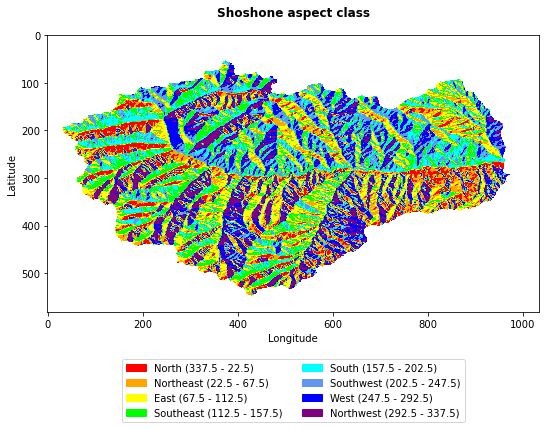

Done


In [84]:
import os
import geospatial_functions.geospatial_plot as gp

root_dir = '/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/discretize'
case = 'shoshone'                                             # user-specified case study name. Used to create a case study foler to store all the case study relevant files.
case_dir = os.path.join(root_dir, case)                       # case study directory. Used to store all the case study relevant files.
aspect_raster = os.path.join(case_dir, 'aspect.tif')           # aspect raster, calcualted based on dem_crop.
stream_shp = os.path.join(case_dir, 'stream.shp')

# # 1. classify aspect into 8 classes
# aspect_class_raster = os.path.join(case_dir, os.path.basename(aspect_raster).split('.tif')[0]+'_class.tif')        
# # # ga.classify_aspect(aspect_raster, 8, aspect_class_raster, nodatavalue)
 
# inraster, class_num, class_outraster, nodatavalue = aspect_raster, 8, aspect_class_raster, nodatavalue
# # read inraster data
# with rio.open(inraster) as ff:
#     data  = ff.read(1)
#     data_mask = ff.read_masks(1)
#     out_meta = ff.meta.copy()
# data_ma = np.ma.masked_array(data, data_mask==255)

# # define array in the same shape of data, and specify dtype!
# data_class = np.ones(np.shape(data), dtype=np.int32)*int(nodatavalue)

# # reclassify aspect
# # reference: https://www.neonscience.org/resources/learning-hub/tutorials/classify-raster-thresholds-py
# if class_num == 4:
#     data_class[np.where((data_ma==0))] = 0                    # flat
#     data_class[np.where((data_ma>0) & (data_ma<=45))] = 1     # north
#     data_class[np.where((data_ma>45) & (data_ma<=135))] = 2   # east
#     data_class[np.where((data_ma>135) & (data_ma<=225))] = 3  # south
#     data_class[np.where((data_ma>225) & (data_ma<=315))] = 4  # west
#     data_class[np.where((data_ma>315) & (data_ma<=360))] = 1  # north
# elif class_num == 8:
#     data_class[np.where((data_ma==0))] = 0                       # flat
#     data_class[np.where((data_ma>0) & (data_ma<=22.5))] = 1      # north
#     data_class[np.where((data_ma>22.5) & (data_ma<=67.5))] = 2   # northeast
#     data_class[np.where((data_ma>67.5) & (data_ma<=112.5))] = 3  # east
#     data_class[np.where((data_ma>112.5) & (data_ma<=157.5))] = 4 # southeast
#     data_class[np.where((data_ma>157.5) & (data_ma<=202.5))] = 5 # south
#     data_class[np.where((data_ma>202.5) & (data_ma<=247.5))] = 6 # southwest
#     data_class[np.where((data_ma>247.5) & (data_ma<=292.5))] = 7 # west
#     data_class[np.where((data_ma>292.5) & (data_ma<=337.5))] = 8 # northwest
#     data_class[np.where((data_ma>337.5) & (data_ma<=360))] = 1   # north

# # mask data_class and data_value
# data_class_ma = np.ma.masked_array(data_class,data_mask==255)

# # save data_class_ma into rasters
# out_meta.update(count=1, dtype='int32', compress='lzw', nodata=nodatavalue)
# with rio.open(class_outraster, 'w', **out_meta) as outf:
#     outf.write(data_class_ma, 1)    

# print('Done')

# 2. plot classified aspect
# define legend dictionary. dist[raster_value]=list(color,label)
legend_dict={0:["black", "Flat (0)"],
             1:["red", "North (337.5 - 22.5)"],
             2:["orange", 'Northeast (22.5 - 67.5)'],
             3:["yellow", 'East (67.5 - 112.5)'], 
             4:["lime", 'Southeast (112.5 - 157.5)'], 
             5:["cyan", 'South (157.5 - 202.5)'], 
             6:["cornflowerblue", 'Southwest (202.5 - 247.5)'], 
             7:["blue", 'West (247.5 - 292.5)'], 
             8:["purple", 'Northwest (292.5 - 337.5)']} 

label_dict = {0:"Flat (0)",
              1:"North (337.7 - 22.5)",
              2:'Northeast (22.5 - 67.5)',
              3:'East (67.5 - 112.5)', 
              4:'Southeast (112.5 - 157.5)', 
              5:'South (157.5 - 202.5)', 
              6:'Southwest (202.5 - 247.5)', 
              7:'West (247.5 - 292.5)', 
              8:'Northwest (292.5 - 337.5)'}

wgs_crs = 'epsg:4326'
figsize=(9,9*0.65) # width, height in inches
title = case.capitalize()+' aspect class'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)
ofile = os.path.join(case_dir, 'plot', 'aspect_class_raw.png')   

# inraster,bound_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile=\
# lc_crop,sub_shp_prj,wgs_crs,'jet',label_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile
inraster,bound_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile,nodatavalue=\
aspect_class_raster,gru_shp,wgs_crs,'user',legend_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile,nodatavalue

# gp.plot_discrete_raster(inraster,bound_vector,wgs_crs,cmap_str,input_dict,
#                         figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile)

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.shutil
import rasterio.plot 
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Part 1. pre-process raster data, color, legend
#  1. reproject raster by creating a VRT file, which is merely a ASCII txt file --- 
# that just contains reference to the referred file. This is useful to avoid duplicating raster files.
# reference: https://geohackweek.github.io/raster/04-workingwithrasters/
raster_vrt_file = os.path.join(os.path.dirname(inraster), 
                            os.path.basename(inraster).split('.')[0]+'_vrt.tif')
with rio.open(inraster) as src:
    with rio.vrt.WarpedVRT(src, crs=wgs_crs, resampling=rio.enums.Resampling.nearest) as vrt:
        rio.shutil.copy(vrt, raster_vrt_file, driver='VRT')

#  2. read the reprojected raster 
with rio.open(raster_vrt_file,nodata=nodatavalue) as src:
    data  = src.read(1)
    data_mask = src.read_masks(1)

data_ma = np.ma.masked_array(data, data_mask==0)
data_unique,data_counts= np.unique(data[data!=nodatavalue],return_counts=True) # unique values and counts

# 3. create colormap, norm and legend (two options)
# method 1. use user-specified cmap
if cmap_str!='user':
    vals = np.arange(int(data_unique.max()+1))/float(data_unique.max())
    colors =  mpl.cm.get_cmap(cmap_str)
    cols = colors(vals)
    cmap = mpl.colors.ListedColormap(cols, int(data_unique.max())+1)

    legend_labels = {}
    count_record = []
    for data_i in data_unique:
        data_i_color = cols[np.where(data_unique==data_i)][0]
        data_i_label = input_dict[data_i]
        legend_labels[data_i]=[data_i_color,data_i_label]
        count_record.append([data_i,data_i_label,int(data_counts[data_unique==data_i])])

# method 2. use user-defined colors
elif cmap_str=='user':

    legend_labels = {} # used to create legend
    count_record = []  # usde to record class count
    colors = []        # used to create cmap
    for data_i in data_unique:
        data_i_color = input_dict[data_i][0] #cols[np.where(unique==data_i)]
        data_i_label = input_dict[data_i][1]
        legend_labels[data_i]=[data_i_color,data_i_label]
        count_record.append([data_i,data_i_label,int(data_counts[data_unique==data_i])])
        colors.append(data_i_color)
    cmap = ListedColormap(colors, len(data_unique)) # Define the colors you want based on raster values    

## Part 2. plot
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
fig.suptitle(title, weight='bold') 


# 2.1. plot raster using rasterio.plot.show in order to show coordinate
raster_image = rasterio.plot.show(data_ma,ax=ax,cmap=cmap)     #transform=src.transform,

# 2.2. plot basin boundary
bound_gpd = gpd.read_file(bound_vector)
bound_gpd_prj = bound_gpd.to_crs(wgs_crs)
bound_gpd_prj['new_column'] = 0
gpd_new = bound_gpd_prj.dissolve(by='new_column')
gpd_new.boundary.plot(color=None,edgecolor='k',linewidth=1,ax=ax) 

# 2.3. plot streamline
stream_gpd = gpd.read_file(stream_shp)
stream_gpd_prj = stream_gpd.to_crs(wgs_crs)
stream_gpd_prj.plot(color='darkblue', linewidth=1.5, ax=ax)

# 2.3. plot legend
if cmap_str!='user':
    patches = [Patch(color=legend_labels[key][0], label=legend_labels[key][1][1]) for key in legend_labels]
else:
    patches = [Patch(color=legend_labels[key][0], label=legend_labels[key][1]) for key in legend_labels]

basin_bound = mpl.patches.Patch(edgecolor='black', linewidth=1, fill=False, label='Basin')
patches.append(basin_bound)

stream_line = mpl.lines.Line2D([], [], color='darkblue', linewidth=1.5, marker=None, label='Streamline')
patches.append(stream_line)

plt.legend(handles=patches, bbox_to_anchor=leg_bbox_to_anchor, loc=leg_loc, ncol=leg_ncol, fancybox=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.savefig(ofile, bbox_inches='tight',dpi=150)   
plt.show()

# 2.5. save count record to txt --- 
count_ofile = os.path.join(os.path.dirname(ofile), os.path.basename(ofile).split('.')[0]+'.txt')
count_sum = np.sum(data_counts)
with open(count_ofile,'w') as f:
    f.write('#RasterValue,Label,Count,Proportion\n')
    for i in range(len(count_record)):
        f.write('%d,%s,%d,%.4f\n'%(count_record[i][0],count_record[i][1],count_record[i][2],
                                   count_record[i][2]/float(count_sum)))  

print('Done')